# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [82]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn import cross_validation
import warnings
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from scipy import sparse
from sklearn import metrics
from sklearn import preprocessing
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from bs4 import BeautifulSoup
from wordcloud import WordCloud 

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

from tqdm import tqdm
import os

In [24]:
# using SQLite Table to read data.
con = sqlite3.connect('C:\\Users\\rahul\\Desktop\\AI COURSE\\Amazon Fine food\\amazon-fine-food-reviews (1)\\database.sqlite')

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [25]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [26]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [27]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [28]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [29]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [30]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [31]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [32]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [33]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [34]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [35]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [36]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [37]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [38]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [39]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [40]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [41]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [42]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [43]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [44]:
# Combining all the above stundents 
from tqdm import tqdm

#Before starting the next phase of preprocessing lets see the number of entries left
final = final.sample(n=100000)
final.shape

print(final.shape)

preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

(100000, 10)


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [01:14<00:00, 1349.49it/s]


In [45]:
preprocessed_reviews[1500]

'originally purchased two containers pounds total try honey making mead course taste little bit pouring six pounds fermenting tank delicious ended keeping bottle open ordering third untainted bottle mead haha orders arrived undamaged well packaged product fantastic really taste slight citrus notes honey darker color run mill grocery store bought nice thick gives mead rich amber color'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [46]:
## Similartly you can do preprocessing for review summary also.
preprocessed_summary = [] 
for sentence in tqdm(final['Summary'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentence.strip())
    
preprocessed_summary[1500]

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:49<00:00, 2005.79it/s]


'super quick shipping delicious'

In [47]:
#FEATURE ENGINEERING

## Take length of each review and use it as a feature
review_len = [len(i) for i in preprocessed_reviews]
#Add summary text and review text to extract as much information as possible
# interlist element concatenation 
combined_text = [i +' '+ j for i, j in zip(preprocessed_reviews, preprocessed_summary)] 

len(review_len)

final['combined_text'] = combined_text
final['review_length'] = review_len

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [48]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

label = final['Score']

# split the data set into train and test
X_train, X_test, y_train, y_test = cross_validation.train_test_split(final, label, test_size=0.3, random_state=0)

type(final)
print(final.head(3))

#Bag of words using Scikit learn
count_vect = CountVectorizer()
vocab = count_vect.fit(X_train['combined_text'].values)
type(vocab)


# #Using the vocab obtained in train to vectorize both train and test data
X_train_bow = vocab.transform(X_train['combined_text'].values)
X_test_bow = vocab.transform(X_test['combined_text'].values)

print(X_train_bow.shape)

X_train_len = X_train['review_length']
X_test_len = X_test['review_length']
X_train_len = X_train_len.values
X_test_len = X_test_len.values

X_train_len = X_train_len.reshape(X_train_len.size,1)
X_test_len = X_test_len.reshape(X_test_len.size,1)


X_train_len = sparse.coo_matrix(X_train_len)
X_test_len = sparse.coo_matrix(X_test_len)

X_trainf = sparse.vstack((X_train_bow.T,X_train_len.T)).T
X_testf = sparse.vstack((X_test_bow.T,X_test_len.T)).T

print(X_trainf.shape)
print(X_testf.shape)

            Id   ProductId          UserId   ProfileName  \
134087  145545  B003D4F1QS   AXOH7LGBMB1DP   jprauschert   
13597    14846  B003N8XO3Q  A2DPYMNI2HCIOI  Angela Evans   
48012    52185  B001FPSZYM   APFQLJ2NQ0SLL      sandrina   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
134087                     0                       0      1  1345593600   
13597                      0                       0      1  1300579200   
48012                      0                       0      1  1246406400   

                                      Summary  \
134087                 stash tea-orange spice   
13597   a nice treat, especially with berries   
48012                             amazing fig   

                                                     Text  \
134087  <a href="http://www.amazon.com/gp/product/B003...   
13597   I love Hunt's sugar free vanilla snack packs. ...   
48012   An extraordinary confit -- perfect for fresh g...   

                

In [111]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate


#function to find the optimal lambda in LR for 5 fold cross validation
def find_optimal_forest(x,y,k):
    
    depth_grid_list = [4,8,12,16,20,24]
    estimators_grid_list =  [25,50,100,150,200,250]
    
    tuned_parameters = [{'max_depth': depth_grid_list, 'n_estimators': estimators_grid_list}]
    model = GridSearchCV(RandomForestClassifier(class_weight='balanced'), tuned_parameters, scoring = 'roc_auc',n_jobs=-1, cv=k,return_train_score = True)
    model.fit(x,y)
    
    train_scores = model.cv_results_['mean_train_score']
    cv_scores = model.cv_results_['mean_test_score']

    train_scores = np.array(train_scores).reshape(len(depth_grid_list), len(estimators_grid_list))
    
    train_scores = np.round(train_scores,3)
    
    print("The Heatmap for Train AUC scores is plotted below: ")
    fig, ax = plt.subplots(figsize=(10,10)) 
    sns.heatmap(train_scores,cbar_kws={'label': 'colorbar title'}, xticklabels=estimators_grid_list, yticklabels=depth_grid_list, linewidths=0.5, linecolor='yellow',annot=True,fmt='g',ax=ax)
    ax.set_xlabel('Esitamators Values')
    ax.set_ylabel('Depth Values')
    plt.show()
    
    cv_scores = np.array(cv_scores).reshape(len(depth_grid_list), len(estimators_grid_list))
    cv_scores = np.round(cv_scores,3)

    print("The Heatmap for Cross-Validation AUC scores is plotted below: ")
    fig, ax = plt.subplots(figsize=(10,10)) 
    sns.heatmap(cv_scores,cbar_kws={'label': 'colorbar title'},xticklabels=estimators_grid_list, yticklabels=depth_grid_list, linewidths=0.5, linecolor='yellow',annot=True,fmt='g',ax=ax)
    # X - Y axis labels
    ax.set_xlabel('Estimators Values')
    ax.set_ylabel('Depth Values')
    plt.show()
    best = model.best_estimator_
    print("The best model obtained from our Gridsearch is: ",best)
    print("The best parameters obtained by our model is: ",model.best_params_)
    print("The AUC score for our model is is: ",np.round(model.best_score_,3))
    
    return model

def find_optimal_gbdt(x,y,k,weight):
    
    depth_grid_list = [4,8,12,16,20]
    estimators_grid_list =  [50,100,150,200]
    
    tuned_parameters = [{'max_depth': depth_grid_list, 'n_estimators': estimators_grid_list}]
    model = GridSearchCV(XGBClassifier(scale_pos_weight=weight), tuned_parameters, scoring = 'roc_auc',n_jobs=-1, cv=k,return_train_score = True)
    model.fit(x,y)
    
    train_scores = model.cv_results_['mean_train_score']
    cv_scores = model.cv_results_['mean_test_score']

    train_scores = np.array(train_scores).reshape(len(depth_grid_list), len(estimators_grid_list))
    
    train_scores = np.round(train_scores,3)
    
    print("The Heatmap for Train AUC scores is plotted below: ")
    fig, ax = plt.subplots(figsize=(10,10)) 
    sns.heatmap(train_scores,cbar_kws={'label': 'colorbar title'}, xticklabels=estimators_grid_list, yticklabels=depth_grid_list, linewidths=0.5, linecolor='yellow',annot=True,fmt='g',ax=ax)
    ax.set_xlabel('Estimators Values')
    ax.set_ylabel('Depth Values')
    plt.show()
    
    cv_scores = np.array(cv_scores).reshape(len(depth_grid_list), len(estimators_grid_list))
    cv_scores = np.round(cv_scores,3)

    print("The Heatmap for Cross-Validation AUC scores is plotted below: ")
    fig, ax = plt.subplots(figsize=(10,10)) 
    sns.heatmap(cv_scores,cbar_kws={'label': 'colorbar title'},xticklabels=estimators_grid_list, yticklabels=depth_grid_list, linewidths=0.5, linecolor='yellow',annot=True,fmt='g',ax=ax)
    # X - Y axis labels
    ax.set_xlabel('Estimators Values')
    ax.set_ylabel('Depth Values')
    plt.show()
    best = model.best_estimator_
    print("The best model obtained from our Gridsearch is: ",best)
    print("The best parameters obtained by our model is: ",model.best_params_)
    print("The AUC score for our model is is: ",np.round(model.best_score_,3))
    
    return model

#function to predict the label of test data and return the same as list 
def pred_test_data(x_tr,y_tr,x_tst,y_tst,model):
    model.fit(x_tr, y_tr)

    # predict the response
    prob = model.predict_proba(x_tst)[:,1]
    
    pred = model.predict(x_tst)
    # evaluate accuracy
    roc = roc_auc_score(y_tst, prob) * 100
    print('\nThe ROC_AUC score of the Decision Tree classifier is: ', roc)
        
    return pred

# def visulize_tree():
#     tree.export_graphviz(clf,out_file="tree.dot",feature_names = fn,class_names=cn,filled = True)
#     dot -Tpng tree.dot -o tree.png
    
#Function to create Confusion matrix creation and plotting the same
def confusion_heatmap(x,y):
    cnf_mat = confusion_matrix(x,y)
    print("Confusion matrix is : " ,cnf_mat )
    print("The True Positive value is:  ",(cnf_mat[1][1]))
    print("The True Negative value is:  ",(cnf_mat[0][0]))
    print("The False Positive value is:  ",(cnf_mat[1][0]))
    print("The False Negative value is:  ",(cnf_mat[0][1]))
    sns.heatmap(cnf_mat,cbar_kws={'label': 'colorbar title'},cmap='YlGnBu',linewidths=2, linecolor='yellow',annot=True,fmt='g')
    
    
def metric_score(x,y):
    print("The precision score for our model is: ", precision_score(x,y)) 
    print("The f1 score for our model is: ", f1_score(x,y))
    print("The recall score for our model is: ", recall_score(x,y))
    print("The accuracy of our model is: ", accuracy_score(x,y))
        

#Function to plot the the roc_auc curve for train and test data    
def plot_roc_curve(xtrain,prob_train,xtest,prob_test,lin1,lin2,l1,l2):
    train_auc = roc_auc_score(xtrain,prob_train)
    fpr,tpr,_ = roc_curve(xtrain,prob_train)
    plt.figure(figsize=(16,8))
    plt.title('Receiver Operating Characteristic')  
    plt.plot(fpr, tpr, linestyle=lin1, label=l1 )
    test_auc = roc_auc_score(xtest,prob_test)
    fpr,tpr,_ = roc_curve(xtest,prob_test)
    plt.plot(fpr, tpr, linestyle=lin2, label=l2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate') 
    plt.legend()
    plt.show()
    
#Function to generate wordcloud given a list of words
def generate_wordcloud(text): # optionally add: stopwords=STOPWORDS and change the arg below
    wordcloud = WordCloud(relative_scaling = 1.0 ).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()


Finding the Optimal Forest using Grid Search: 
The Heatmap for Train AUC scores is plotted below: 


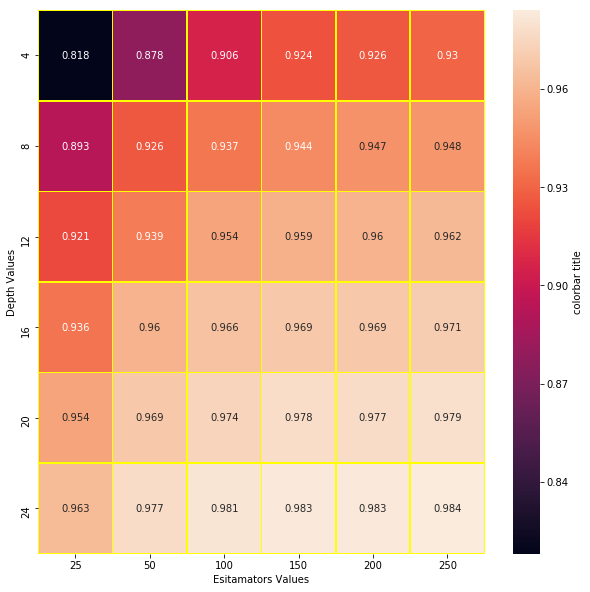

The Heatmap for Cross-Validation AUC scores is plotted below: 


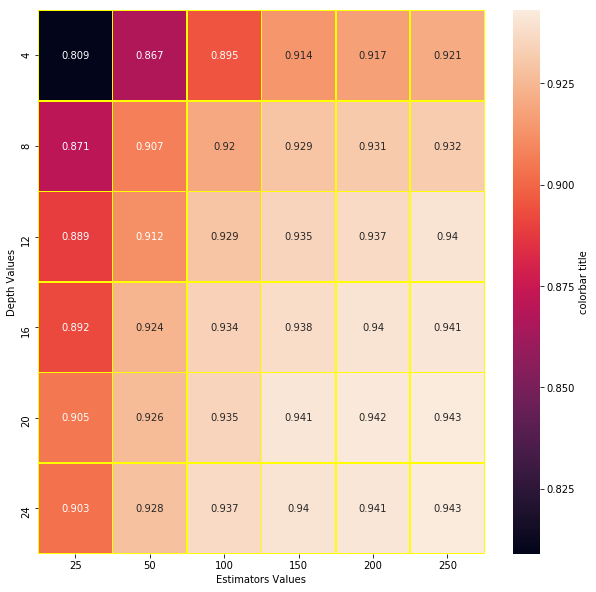

The best model obtained from our Gridsearch is:  RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=250, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
The best parameters obtained by our model is:  {'max_depth': 20, 'n_estimators': 250}
The AUC score for our model is is:  0.943


In [51]:
# find the optimal plane using grid search 

encoder = preprocessing.LabelEncoder()
enc = encoder.fit(y_train)
y_en_train= enc.transform(y_train)
y_en_test = enc.transform(y_test)


# print(X_train)
print("Finding the Optimal Forest using Grid Search: ")
opt_forest = find_optimal_forest(X_trainf,y_en_train,3)


In [52]:
opt_forest_best = opt_forest.best_estimator_

y_pred = pred_test_data(X_trainf,y_en_train,X_testf,y_en_test,opt_forest_best) 


The ROC_AUC score of the Decision Tree classifier is:  94.8800821258369


Confusion matrix is :  [[ 3807   910]
 [ 1805 23478]]
The True Positive value is:   23478
The True Negative value is:   3807
The False Positive value is:   1805
The False Negative value is:   910


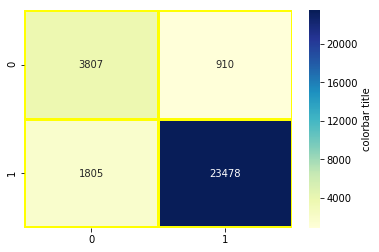

In [53]:
confusion_heatmap(y_en_test,y_pred)

In [54]:
#determining metrics precision,recall,f-1 scores for our model
metric_score(y_en_test,y_pred)

The precision score for our model is:  0.9626865671641791
The f1 score for our model is:  0.9453403394334723
The recall score for our model is:  0.9286081556777281
The accuracy of our model is:  0.9095


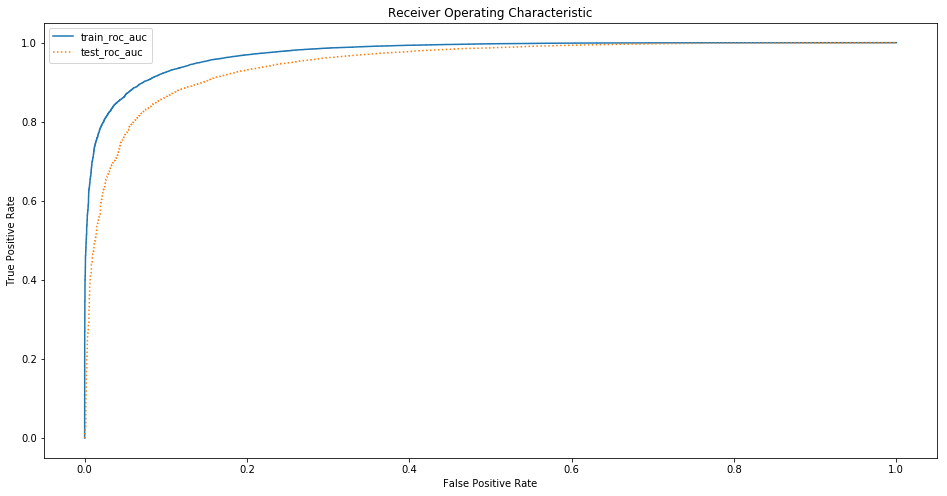

In [55]:
ytrain_prob = opt_forest_best.predict_proba(X_trainf)
ytrain_prob = ytrain_prob[:, 1]

ytest_prob = opt_forest_best.predict_proba(X_testf)
ytest_prob = ytest_prob[:,1]
#get the class probabilities for train and test to plot the roc curve 
plot_roc_curve(y_en_train,ytrain_prob,y_en_test,ytest_prob,'-',':',"train_roc_auc","test_roc_auc")

### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

The wordcloud for top 20 features are:


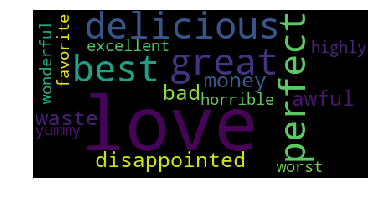

In [56]:
# Please write all the code with proper documentation
#Top 20 features for classification 
#Use negation to sort in descending
top_words_sorted = np.argsort(-opt_forest_best.feature_importances_)
top_text = np.take(count_vect.get_feature_names(), top_words_sorted[:20])

topi_text = " ".join(words for words in top_text)

print("The wordcloud for top 20 features are:")
generate_wordcloud(topi_text)


Conclusion:
1. Random Forests with 3-fold validation was performed on a sample dataset of AFF for BOW vectors.
2. We chose the standard 70-30 split i.e. 70% as train data and 30% as test data.
4. Confusion matrix was plotted for the same. We got True Negative value of 3807 and True Positive value of 23478.
5. The accuracy,precision, recall and f1 scores are 90.95 % , 96.27%, 92.86% and 94.53 % respectively. 
6. Also we obtained the top 20 features as random forests give feature importances


### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [57]:
# Please write all the code with proper documentation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(final, label, test_size=0.3, random_state=0)
#Converting text into vector using tfidf vectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),max_features=100000)
vocab = tf_idf_vect.fit(X_train['combined_text'].values)
X_train_tfidf = vocab.transform(X_train['combined_text'].values)
X_test_tfidf = vocab.transform(X_test['combined_text'].values)

X_trainf = sparse.vstack((X_train_tfidf.T,X_train_len.T)).T
X_testf = sparse.vstack((X_test_tfidf.T,X_test_len.T)).T

print(X_trainf.shape)

(70000, 100001)


Finding the Optimal Forest using Grid Search: 
The Heatmap for Train AUC scores is plotted below: 


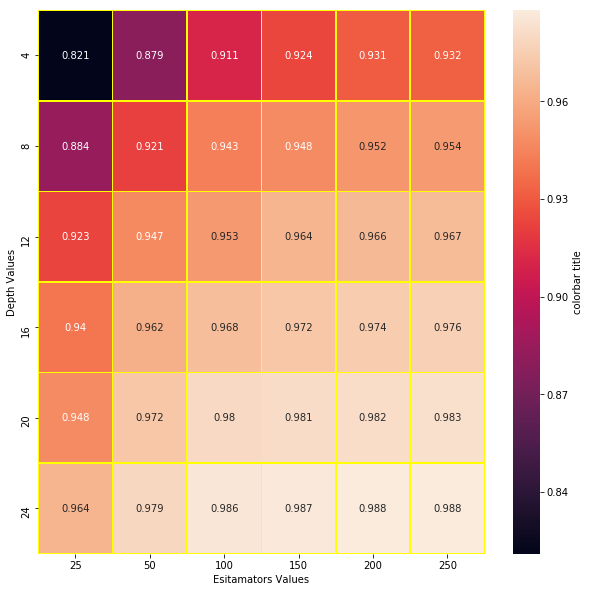

The Heatmap for Cross-Validation AUC scores is plotted below: 


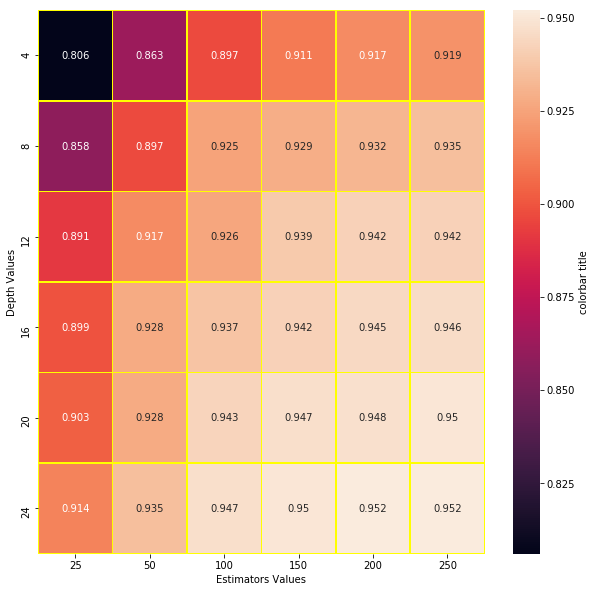

The best model obtained from our Gridsearch is:  RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=24, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=250, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
The best parameters obtained by our model is:  {'max_depth': 24, 'n_estimators': 250}
The AUC score for our model is is:  0.952


In [58]:
print("Finding the Optimal Forest using Grid Search: ")
opt_forest = find_optimal_forest(X_trainf,y_en_train,3)

In [59]:
opt_forest_best = opt_forest.best_estimator_

y_pred = pred_test_data(X_trainf,y_en_train,X_testf,y_en_test,opt_forest_best) 


The ROC_AUC score of the Decision Tree classifier is:  95.66407105569616


Confusion matrix is :  [[ 3728   989]
 [ 1380 23903]]
The True Positive value is:   23903
The True Negative value is:   3728
The False Positive value is:   1380
The False Negative value is:   989


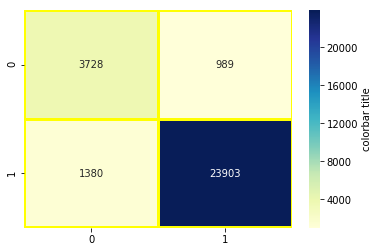

In [60]:
confusion_heatmap(y_en_test,y_pred)

In [61]:
#determining metrics precision,recall,f-1 scores for our model
metric_score(y_en_test,y_pred)

The precision score for our model is:  0.9602683593122289
The f1 score for our model is:  0.9527852516193323
The recall score for our model is:  0.9454178697148281
The accuracy of our model is:  0.9210333333333334


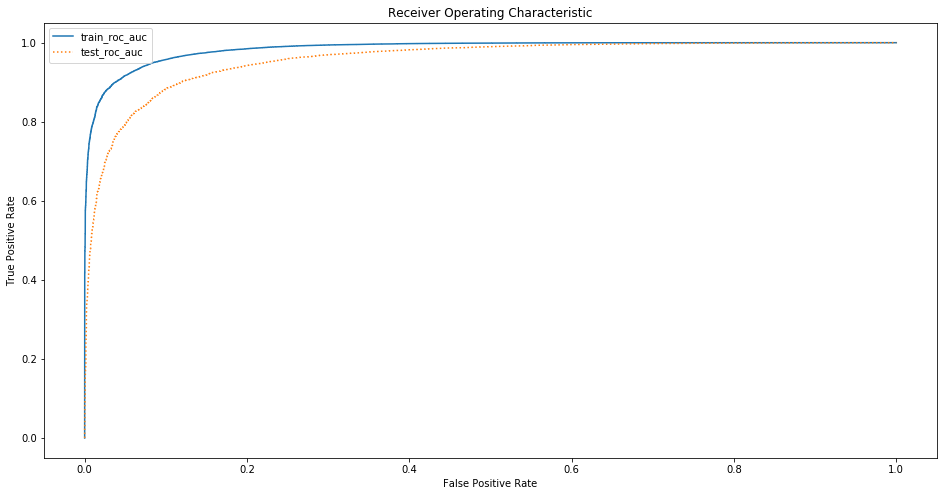

In [62]:
ytrain_prob = opt_forest_best.predict_proba(X_trainf)
ytrain_prob = ytrain_prob[:, 1]

ytest_prob = opt_forest_best.predict_proba(X_testf)
ytest_prob = ytest_prob[:,1]
#get the class probabilities for train and test to plot the roc curve 
plot_roc_curve(y_en_train,ytrain_prob,y_en_test,ytest_prob,'-',':',"train_roc_auc","test_roc_auc")

### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

The wordcloud for top 20 features are:


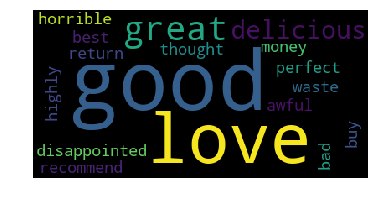

In [64]:
# Please write all the code with proper documentation
#Top 20 features for classification 
#Use negation to sort in descending
top_words_sorted = np.argsort(-opt_forest_best.feature_importances_)
top_text = np.take(tf_idf_vect.get_feature_names(), top_words_sorted[:20])

topi_text = " ".join(words for words in top_text)

print("The wordcloud for top 20 features are:")
generate_wordcloud(topi_text)


Conclusion:
1. Random Forests with 3-fold validation was performed on a sample dataset of AFF for TF-IDF vectors.
2. We chose the standard 70-30 split i.e. 70% as train data and 30% as test data.
4. Confusion matrix was plotted for the same. We got True Negative value of 3728 and True Positive value of 23903.
5. The accuracy,precision, recall and f1 scores are 92.10 % , 96.03%, 94.54% and 95.28 % respectively. 
6. Also we obtained the top 20 features as random forests give feature importances



### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [65]:
# Please write all the code with proper documentation
# Train your own Word2Vec model using your own text corpus
X_train, X_test, y_train, y_test = cross_validation.train_test_split(final, label, test_size=0.3, random_state=0)

i=0

list_of_sentance=[]
for sentance in X_train['combined_text']:
    list_of_sentance.append(sentance.split())

# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

# average Word2Vec
# compute average word2vec for each review.
sent_train_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_train_vectors.append(sent_vec)
print(len(sent_train_vectors))
print(len(sent_train_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 70000/70000 [05:38<00:00, 206.68it/s]


70000
50


In [66]:
i=0
list_of_sentance=[]
for sentance in X_test['combined_text']:
    list_of_sentance.append(sentance.split())

# average Word2Vec
# compute average word2vec for each review.
sent_test_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_test_vectors.append(sent_vec)
print(len(sent_test_vectors))
print(len(sent_test_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [02:00<00:00, 249.73it/s]


30000
50


In [67]:
X_train_w2v = np.array(sent_train_vectors)
X_test_w2v = np.array(sent_test_vectors)

X_trainf = sparse.vstack((X_train_w2v.T,X_train_len.T)).T
X_testf = sparse.vstack((X_test_w2v.T,X_test_len.T)).T

print(X_trainf.shape)

(70000, 51)


Finding the Optimal Forest using Grid Search: 
The Heatmap for Train AUC scores is plotted below: 


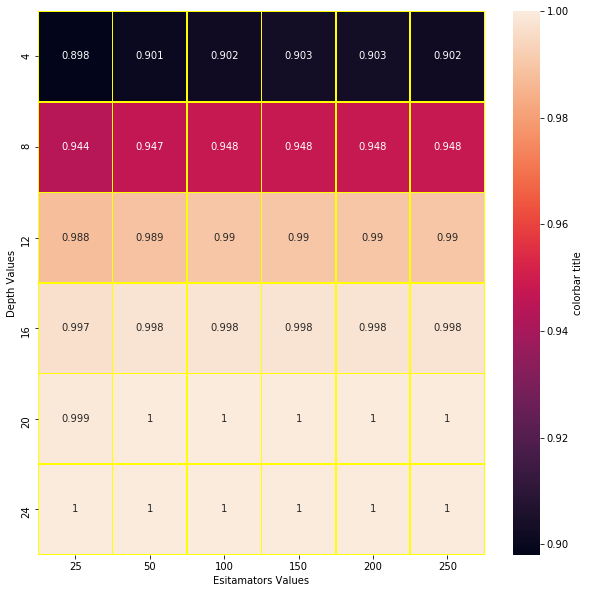

The Heatmap for Cross-Validation AUC scores is plotted below: 


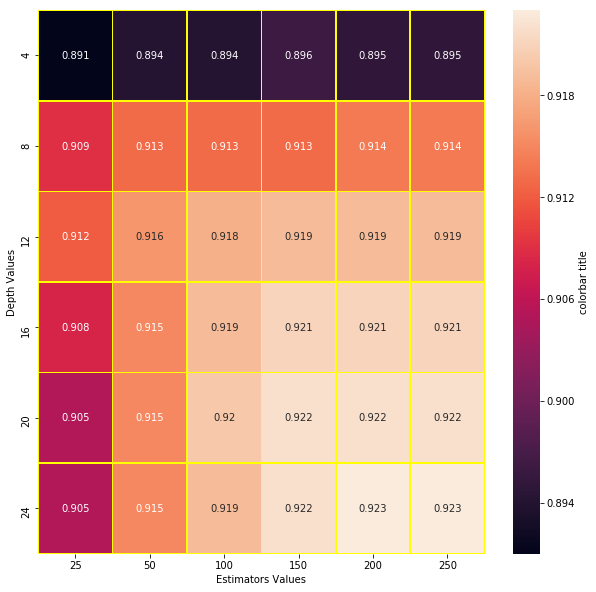

The best model obtained from our Gridsearch is:  RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=24, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
The best parameters obtained by our model is:  {'max_depth': 24, 'n_estimators': 200}
The AUC score for our model is is:  0.923


In [68]:
print("Finding the Optimal Forest using Grid Search: ")
opt_forest = find_optimal_forest(X_trainf,y_en_train,3)

In [69]:
opt_forest_best = opt_forest.best_estimator_
y_pred = pred_test_data(X_trainf,y_en_train,X_testf,y_en_test,opt_forest_best) 


The ROC_AUC score of the Decision Tree classifier is:  92.74034004603608


Confusion matrix is :  [[ 2075  2642]
 [  553 24730]]
The True Positive value is:   24730
The True Negative value is:   2075
The False Positive value is:   553
The False Negative value is:   2642


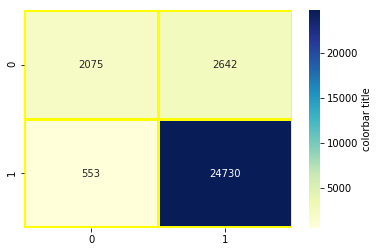

In [70]:
confusion_heatmap(y_en_test,y_pred)

In [71]:
#determining metrics precision,recall,f-1 scores for our model
metric_score(y_en_test,y_pred)

The precision score for our model is:  0.9034780067221979
The f1 score for our model is:  0.9393220017092394
The recall score for our model is:  0.9781275956176086
The accuracy of our model is:  0.8935


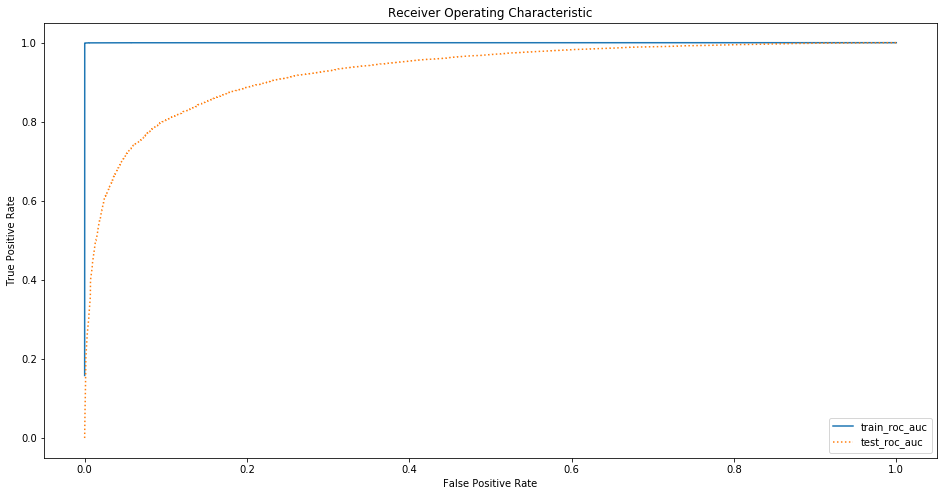

In [73]:
ytrain_prob = opt_forest_best.predict_proba(X_trainf)
ytrain_prob = ytrain_prob[:, 1]

ytest_prob = opt_forest_best.predict_proba(X_testf)
ytest_prob = ytest_prob[:,1]
#get the class probabilities for train and test to plot the roc curve 
plot_roc_curve(y_en_train,ytrain_prob,y_en_test,ytest_prob,'-',':',"train_roc_auc","test_roc_auc")

Conclusion:
1. Random Forests with 3-fold validation was performed on a sample dataset of AFF for average word2vec.
2. We chose the standard 70-30 split i.e. 70% as train data and 30% as test data.
4. Confusion matrix was plotted for the same. We got True Negative value of 2075 and True Positive value of 24730.
5. The accuracy,precision, recall and f1 scores are 89.35 % , 90.35%, 97.81% and 93.93 % respectively. 


### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [74]:
# # Please write all the code with proper documentation
# # TF-IDF weighted Word2Vec

#as it takes a lot of time, after mail consulation with team, taking 10k points
final_tf_w2v = final.sample(n=10000)
label_tf_w2v = final_tf_w2v['Score']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(final_tf_w2v, label_tf_w2v, test_size=0.3, random_state=0)
#fetching the list of sentences from cleanedtext column of our train data for word2vec model    
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))

# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
vocab = tf_idf_vect.fit_transform(X_train['combined_text'].values)
# X_train_tfidf = vocab.transform(X_train['combined_text'].values)
X_test_tfidf = tf_idf_vect.transform(X_test['combined_text'].values)

i=0
list_of_sent=[]
for sent in X_train['combined_text'].values:
    list_of_sent.append(sent.split())

# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
    
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))
type(X_train)

tfidf_train_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;


for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1
    
X_train_tfw2v = tfidf_train_vectors



100%|██████████████████████████████████████████████████████████████████████████████| 7000/7000 [31:28<00:00,  5.04it/s]


In [75]:
i=0
list_of_sent=[]
for sent in X_test['combined_text'].values:
    list_of_sent.append(sent.split())

tfidf_test_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;

for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1
    
X_test_tfw2v = tfidf_test_vectors

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [13:19<00:00,  2.09it/s]


In [76]:
X_train_w2v = np.array(tfidf_train_vectors)
X_test_w2v = np.array(tfidf_test_vectors)

X_train, X_test, y_train, y_test = cross_validation.train_test_split(final_tf_w2v, label_tf_w2v, test_size=0.3, random_state=0)
X_train_len = X_train['review_length']
X_test_len = X_test['review_length']
X_train_len = X_train_len.values
X_test_len = X_test_len.values

X_train_len = X_train_len.reshape(X_train_len.size,1)
X_test_len = X_test_len.reshape(X_test_len.size,1)


X_train_len = sparse.coo_matrix(X_train_len)
X_test_len = sparse.coo_matrix(X_test_len)


X_trainf = sparse.vstack((X_train_w2v.T,X_train_len.T)).T
X_testf = sparse.vstack((X_test_w2v.T,X_test_len.T)).T

print(X_trainf.shape)

(7000, 51)


Finding the Optimal Forest using Grid Search: 
The Heatmap for Train AUC scores is plotted below: 


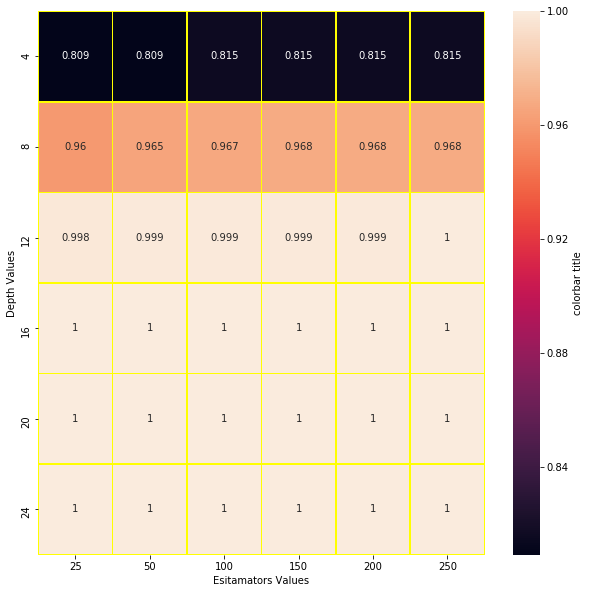

The Heatmap for Cross-Validation AUC scores is plotted below: 


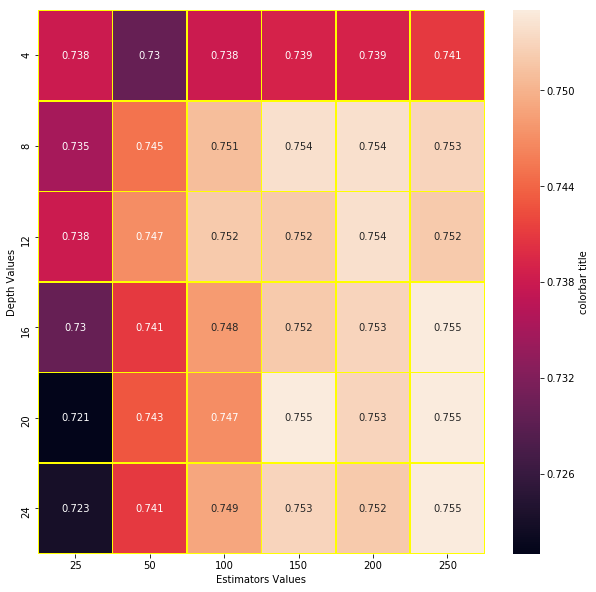

The best model obtained from our Gridsearch is:  RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=24, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=250, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
The best parameters obtained by our model is:  {'max_depth': 24, 'n_estimators': 250}
The AUC score for our model is is:  0.755


In [77]:
# find the optimal plane using grid search 

encoder = preprocessing.LabelEncoder()
enc = encoder.fit(y_train)
y_en_train= enc.transform(y_train)
y_en_test = enc.transform(y_test)

print("Finding the Optimal Forest using Grid Search: ")
opt_forest = find_optimal_forest(X_trainf,y_en_train,3)

In [78]:
opt_forest_best = opt_forest.best_estimator_
y_pred = pred_test_data(X_trainf,y_en_train,X_testf,y_en_test,opt_forest_best) 


The ROC_AUC score of the Decision Tree classifier is:  77.72929558522414


Confusion matrix is :  [[  35  436]
 [  24 2505]]
The True Positive value is:   2505
The True Negative value is:   35
The False Positive value is:   24
The False Negative value is:   436


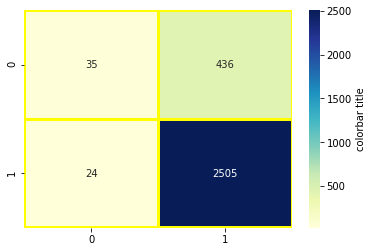

In [79]:
confusion_heatmap(y_en_test,y_pred)

In [80]:
#determining metrics precision,recall,f-1 scores for our model
metric_score(y_en_test,y_pred)

The precision score for our model is:  0.851751105066304
The f1 score for our model is:  0.9159049360146253
The recall score for our model is:  0.9905100830367735
The accuracy of our model is:  0.8466666666666667


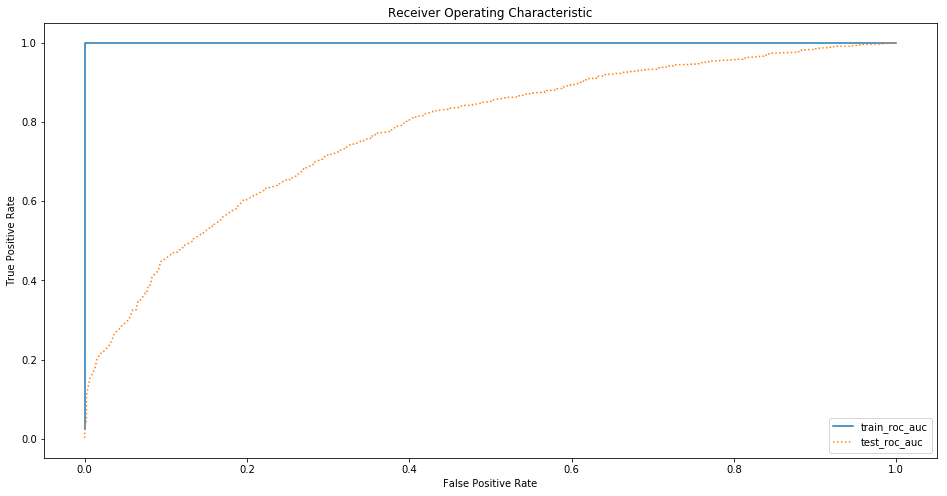

In [81]:
ytrain_prob = opt_forest_best.predict_proba(X_trainf)
ytrain_prob = ytrain_prob[:, 1]

ytest_prob = opt_forest_best.predict_proba(X_testf)
ytest_prob = ytest_prob[:,1]
#get the class probabilities for train and test to plot the roc curve 
plot_roc_curve(y_en_train,ytrain_prob,y_en_test,ytest_prob,'-',':',"train_roc_auc","test_roc_auc")

Conclusion:
1. Random Forests with 3-fold validation was performed on a sample dataset of AFF for tf-idf average word2vec.
2. We chose the standard 70-30 split i.e. 70% as train data and 30% as test data.
4. Confusion matrix was plotted for the same. We got True Negative value of 35 and True Positive value of 2505.
5. The accuracy,precision, recall and f1 scores are 84.67 % , 85.17%, 99.05% and 91.59 % respectively. 


## [5.2] Applying GBDT using XGBOOST

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [112]:
# Please write all the code with proper documentation
#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

label = final['Score']

# split the data set into train and test
X_train, X_test, y_train, y_test = cross_validation.train_test_split(final, label, test_size=0.3, random_state=0)

type(final)
print(final.head(3))

#Bag of words using Scikit learn
count_vect = CountVectorizer()
vocab = count_vect.fit(X_train['combined_text'].values)
type(vocab)


# #Using the vocab obtained in train to vectorize both train and test data
X_train_bow = vocab.transform(X_train['combined_text'].values)
X_test_bow = vocab.transform(X_test['combined_text'].values)

print(X_train_bow.shape)

X_train_len = X_train['review_length']
X_test_len = X_test['review_length']
X_train_len = X_train_len.values
X_test_len = X_test_len.values

X_train_len = X_train_len.reshape(X_train_len.size,1)
X_test_len = X_test_len.reshape(X_test_len.size,1)


X_train_len = sparse.coo_matrix(X_train_len)
X_test_len = sparse.coo_matrix(X_test_len)

X_trainf = sparse.vstack((X_train_bow.T,X_train_len.T)).T
X_testf = sparse.vstack((X_test_bow.T,X_test_len.T)).T

print(X_trainf.shape)
print(X_testf.shape)

            Id   ProductId          UserId   ProfileName  \
134087  145545  B003D4F1QS   AXOH7LGBMB1DP   jprauschert   
13597    14846  B003N8XO3Q  A2DPYMNI2HCIOI  Angela Evans   
48012    52185  B001FPSZYM   APFQLJ2NQ0SLL      sandrina   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
134087                     0                       0      1  1345593600   
13597                      0                       0      1  1300579200   
48012                      0                       0      1  1246406400   

                                      Summary  \
134087                 stash tea-orange spice   
13597   a nice treat, especially with berries   
48012                             amazing fig   

                                                     Text  \
134087  <a href="http://www.amazon.com/gp/product/B003...   
13597   I love Hunt's sugar free vanilla snack packs. ...   
48012   An extraordinary confit -- perfect for fresh g...   

                

Finding the Optimal GBDT using Grid Search: 
The Heatmap for Train AUC scores is plotted below: 


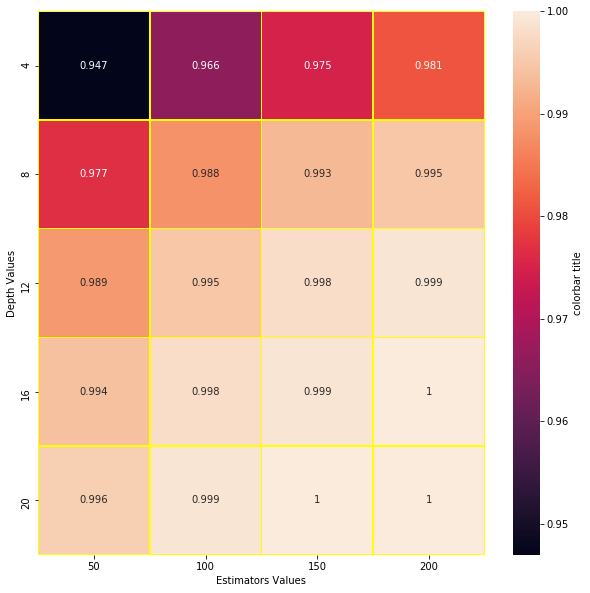

The Heatmap for Cross-Validation AUC scores is plotted below: 


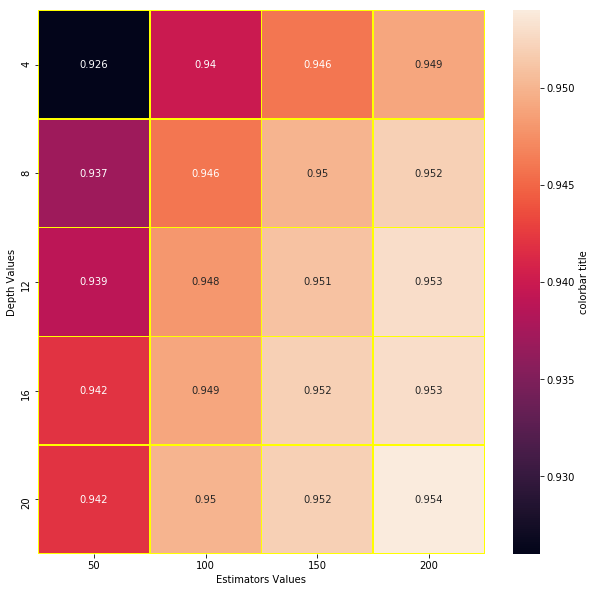

The best model obtained from our Gridsearch is:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.300000012, max_delta_step=0, max_depth=20,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=200, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=0.187, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None)
The best parameters obtained by our model is:  {'max_depth': 20, 'n_estimators': 200}
The AUC score for our model is is:  0.954


In [114]:
weight = sum(final['Score']==0)/sum(final['Score']==1)
weight = round(weight,3)

# find the optimal plane using grid search 

encoder = preprocessing.LabelEncoder()
enc = encoder.fit(y_train)
y_en_train= enc.transform(y_train)
y_en_test = enc.transform(y_test)

# print(X_train)
print("Finding the Optimal GBDT using Grid Search: ")
opt_gbdt = find_optimal_gbdt(X_trainf,y_en_train,2,weight)


In [115]:
opt_gbdt_best = opt_gbdt.best_estimator_

y_pred = pred_test_data(X_trainf,y_en_train,X_testf,y_en_test,opt_gbdt_best) 


The ROC_AUC score of the Decision Tree classifier is:  96.35091250403498


Confusion matrix is :  [[ 3783   934]
 [ 1194 24089]]
The True Positive value is:   24089
The True Negative value is:   3783
The False Positive value is:   1194
The False Negative value is:   934


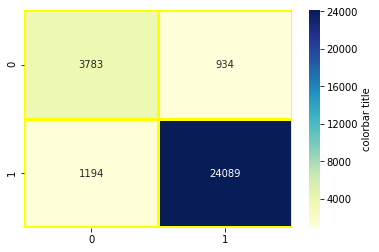

In [116]:
confusion_heatmap(y_en_test,y_pred)

In [117]:
#determining metrics precision,recall,f-1 scores for our model
metric_score(y_en_test,y_pred)

The precision score for our model is:  0.962674339607561
The f1 score for our model is:  0.9576988828370372
The recall score for our model is:  0.9527745916228295
The accuracy of our model is:  0.9290666666666667


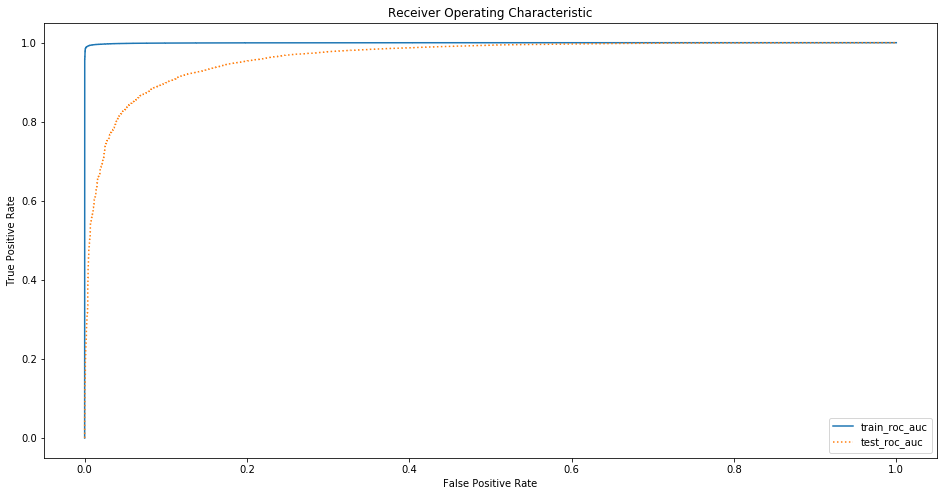

In [119]:
ytrain_prob = opt_gbdt_best.predict_proba(X_trainf)
ytrain_prob = ytrain_prob[:, 1]

ytest_prob = opt_gbdt_best.predict_proba(X_testf)
ytest_prob = ytest_prob[:,1]
#get the class probabilities for train and test to plot the roc curve 
plot_roc_curve(y_en_train,ytrain_prob,y_en_test,ytest_prob,'-',':',"train_roc_auc","test_roc_auc")

The wordcloud for top 20 features are:


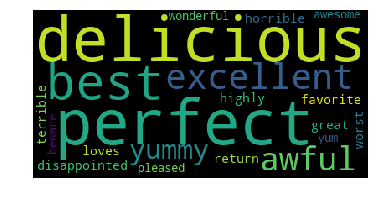

In [120]:
# Please write all the code with proper documentation
#Top 20 features for classification 
#Use negation to sort in descending
top_words_sorted = np.argsort(-opt_gbdt_best.feature_importances_)
top_text = np.take(count_vect.get_feature_names(), top_words_sorted[:20])

topi_text = " ".join(words for words in top_text)

print("The wordcloud for top 20 features are:")
generate_wordcloud(topi_text)


Conclusion:
1. GBDT with 2-fold validation was performed on a sample dataset of AFF for BOW vectors.
2. We chose the standard 70-30 split i.e. 70% as train data and 30% as test data.
4. Confusion matrix was plotted for the same. We got True Negative value of 3783 and True Positive value of 24089.
5. The accuracy,precision, recall and f1 scores are 92.91 % , 96.27 %, 95.28 % and 95.77 % respectively. 
6. Also we obtained the top 20 features as random forests give feature importances


### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

In [121]:
# Please write all the code with proper documentation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(final, label, test_size=0.3, random_state=0)
#Converting text into vector using tfidf vectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),max_features=100000)
vocab = tf_idf_vect.fit(X_train['combined_text'].values)
X_train_tfidf = vocab.transform(X_train['combined_text'].values)
X_test_tfidf = vocab.transform(X_test['combined_text'].values)

X_trainf = sparse.vstack((X_train_tfidf.T,X_train_len.T)).T
X_testf = sparse.vstack((X_test_tfidf.T,X_test_len.T)).T

print(X_trainf.shape)

(70000, 100001)


Finding the Optimal GBDT using Grid Search: 
The Heatmap for Train AUC scores is plotted below: 


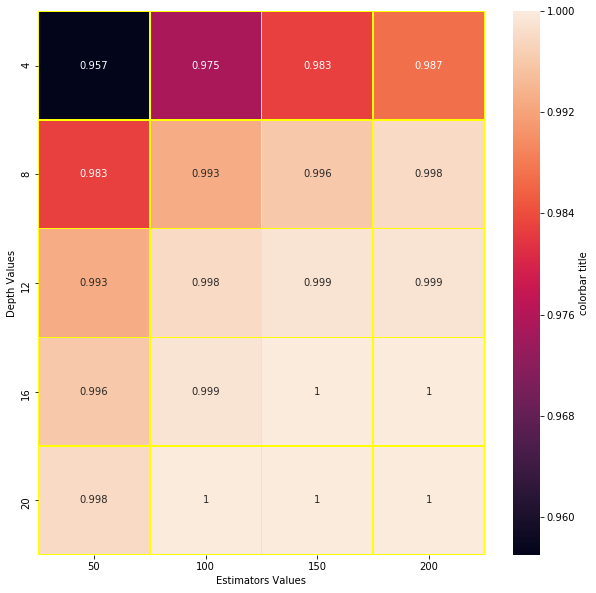

The Heatmap for Cross-Validation AUC scores is plotted below: 


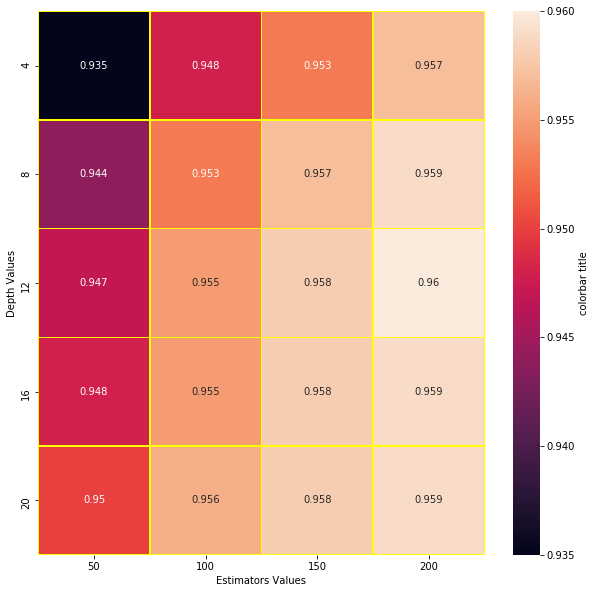

The best model obtained from our Gridsearch is:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.300000012, max_delta_step=0, max_depth=12,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=200, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=0.187, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None)
The best parameters obtained by our model is:  {'max_depth': 12, 'n_estimators': 200}
The AUC score for our model is is:  0.96


In [123]:
print("Finding the Optimal GBDT using Grid Search: ")
opt_gbdt = find_optimal_gbdt(X_trainf,y_en_train,2,weight)

In [124]:
opt_gbdt_best = opt_gbdt.best_estimator_

y_pred = pred_test_data(X_trainf,y_en_train,X_testf,y_en_test,opt_gbdt_best) 


The ROC_AUC score of the Decision Tree classifier is:  96.82826276803108


Confusion matrix is :  [[ 3996   721]
 [ 1346 23937]]
The True Positive value is:   23937
The True Negative value is:   3996
The False Positive value is:   1346
The False Negative value is:   721


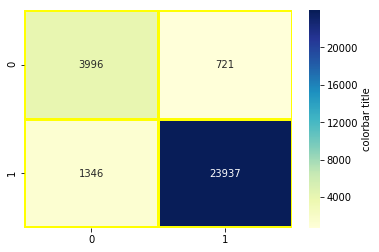

In [125]:
confusion_heatmap(y_en_test,y_pred)

In [126]:
#determining metrics precision,recall,f-1 scores for our model
metric_score(y_en_test,y_pred)

The precision score for our model is:  0.9707599967556169
The f1 score for our model is:  0.9586111611701809
The recall score for our model is:  0.9467626468377961
The accuracy of our model is:  0.9311


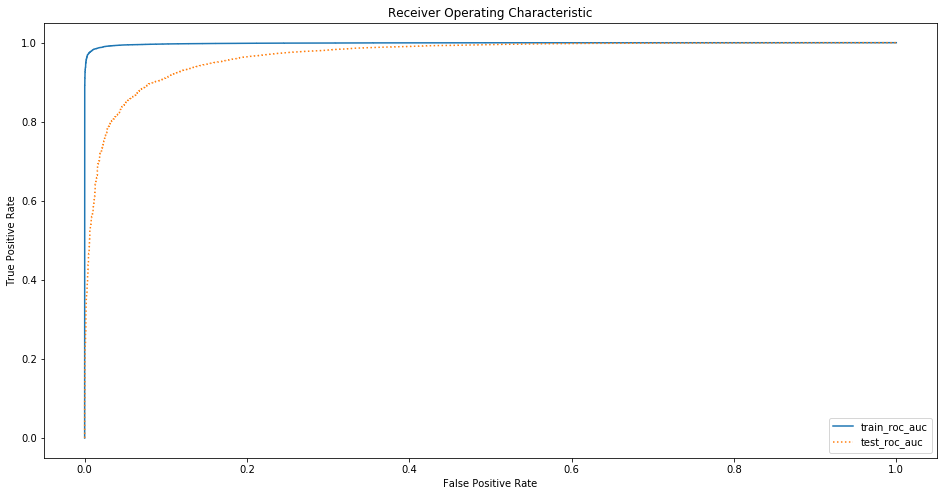

In [127]:
ytrain_prob = opt_gbdt_best.predict_proba(X_trainf)
ytrain_prob = ytrain_prob[:, 1]

ytest_prob = opt_gbdt_best.predict_proba(X_testf)
ytest_prob = ytest_prob[:,1]
#get the class probabilities for train and test to plot the roc curve 
plot_roc_curve(y_en_train,ytrain_prob,y_en_test,ytest_prob,'-',':',"train_roc_auc","test_roc_auc")

The wordcloud for top 20 features are:


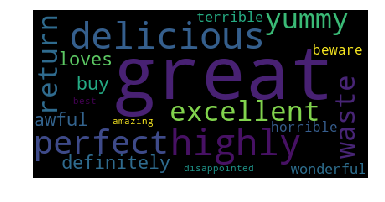

In [128]:
# Please write all the code with proper documentation
#Top 20 features for classification 
#Use negation to sort in descending
top_words_sorted = np.argsort(-opt_gbdt_best.feature_importances_)
top_text = np.take(tf_idf_vect.get_feature_names(), top_words_sorted[:20])

topi_text = " ".join(words for words in top_text)

print("The wordcloud for top 20 features are:")
generate_wordcloud(topi_text)


Conclusion:
1. GBDT with 2-fold validation was performed on a sample dataset of AFF for TF-IDF vectors.
2. We chose the standard 70-30 split i.e. 70% as train data and 30% as test data.
4. Confusion matrix was plotted for the same. We got True Negative value of 3783 and True Positive value of 24089.
5. The accuracy,precision, recall and f1 scores are 93.11 % , 97.07 %, 94.68 % and 95.86 % respectively. 
6. Also we obtained the top 20 features as random forests give feature importances


### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [129]:
# Please write all the code with proper documentation
# Train your own Word2Vec model using your own text corpus
X_train, X_test, y_train, y_test = cross_validation.train_test_split(final, label, test_size=0.3, random_state=0)

i=0

list_of_sentance=[]
for sentance in X_train['combined_text']:
    list_of_sentance.append(sentance.split())

# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

# average Word2Vec
# compute average word2vec for each review.
sent_train_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_train_vectors.append(sent_vec)
print(len(sent_train_vectors))
print(len(sent_train_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 70000/70000 [03:50<00:00, 303.95it/s]


70000
50


In [130]:
i=0
list_of_sentance=[]
for sentance in X_test['combined_text']:
    list_of_sentance.append(sentance.split())

# average Word2Vec
# compute average word2vec for each review.
sent_test_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_test_vectors.append(sent_vec)
print(len(sent_test_vectors))
print(len(sent_test_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [01:36<00:00, 310.26it/s]


30000
50


In [131]:
X_train_w2v = np.array(sent_train_vectors)
X_test_w2v = np.array(sent_test_vectors)

X_trainf = sparse.vstack((X_train_w2v.T,X_train_len.T)).T
X_testf = sparse.vstack((X_test_w2v.T,X_test_len.T)).T

print(X_trainf.shape)

(70000, 51)


Finding the Optimal GBDT using Grid Search: 
The Heatmap for Train AUC scores is plotted below: 


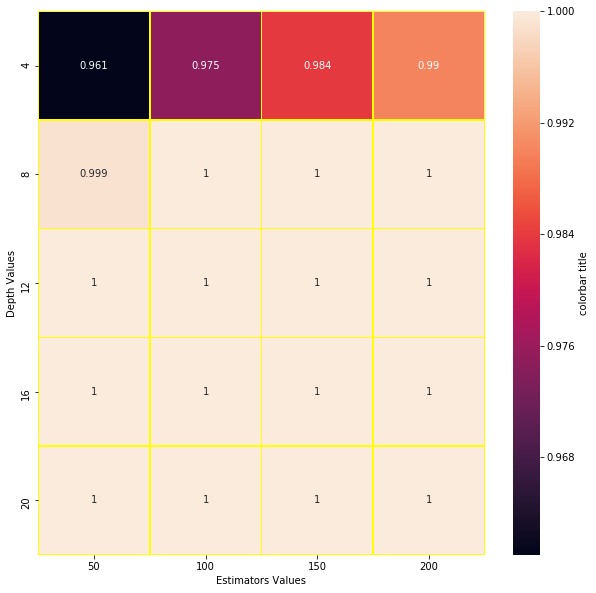

The Heatmap for Cross-Validation AUC scores is plotted below: 


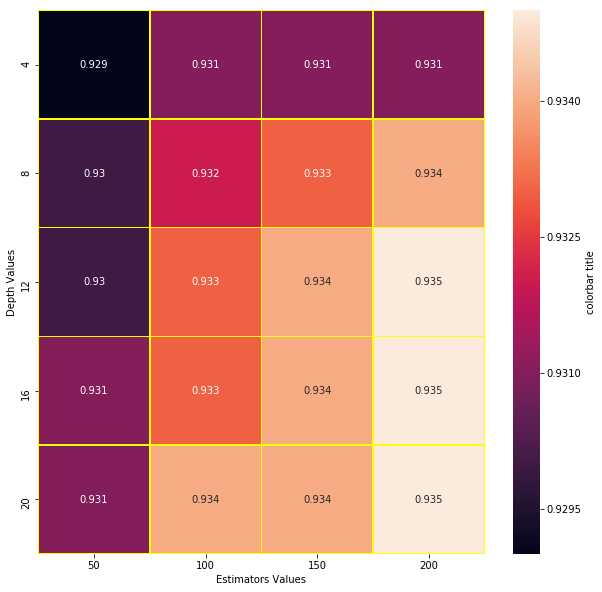

The best model obtained from our Gridsearch is:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.300000012, max_delta_step=0, max_depth=12,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=200, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=0.187, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None)
The best parameters obtained by our model is:  {'max_depth': 12, 'n_estimators': 200}
The AUC score for our model is is:  0.935


In [132]:
print("Finding the Optimal GBDT using Grid Search: ")
opt_gbdt = find_optimal_gbdt(X_trainf,y_en_train,2,weight)

In [133]:
opt_gbdt_best = opt_gbdt.best_estimator_
y_pred = pred_test_data(X_trainf,y_en_train,X_testf,y_en_test,opt_gbdt_best) 


The ROC_AUC score of the Decision Tree classifier is:  93.97157105039263


Confusion matrix is :  [[ 3219  1498]
 [ 1176 24107]]
The True Positive value is:   24107
The True Negative value is:   3219
The False Positive value is:   1176
The False Negative value is:   1498


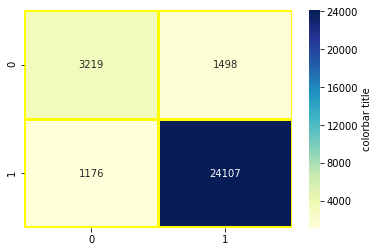

In [134]:
confusion_heatmap(y_en_test,y_pred)

In [135]:
#determining metrics precision,recall,f-1 scores for our model
metric_score(y_en_test,y_pred)

The precision score for our model is:  0.9414958016012498
The f1 score for our model is:  0.9474532306241157
The recall score for our model is:  0.9534865324526361
The accuracy of our model is:  0.9108666666666667


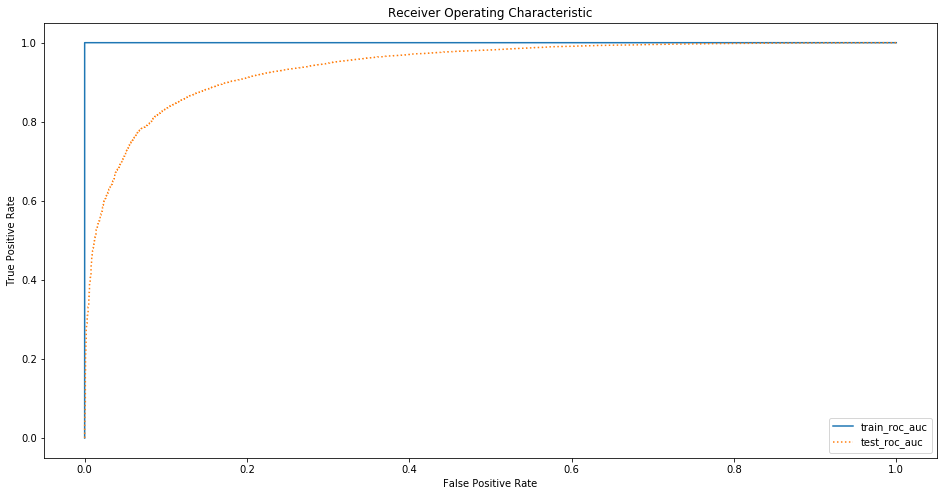

In [136]:
ytrain_prob = opt_gbdt_best.predict_proba(X_trainf)
ytrain_prob = ytrain_prob[:, 1]

ytest_prob = opt_gbdt_best.predict_proba(X_testf)
ytest_prob = ytest_prob[:,1]
#get the class probabilities for train and test to plot the roc curve 
plot_roc_curve(y_en_train,ytrain_prob,y_en_test,ytest_prob,'-',':',"train_roc_auc","test_roc_auc")

Conclusion:
1. GBDT with 2-fold validation was performed on a sample dataset of AFF for Avg Word2vec vectors.
2. We chose the standard 70-30 split i.e. 70% as train data and 30% as test data.
4. Confusion matrix was plotted for the same. We got True Negative value of 3219 and True Positive value of 24107.
5. The accuracy,precision, recall and f1 scores are 91.09 % , 94.15 %, 95.35 % and 94.74 % respectively. 


### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [137]:
# Please write all the code with proper documentation
X_train_w2v = np.array(tfidf_train_vectors)
X_test_w2v = np.array(tfidf_test_vectors)

X_train, X_test, y_train, y_test = cross_validation.train_test_split(final_tf_w2v, label_tf_w2v, test_size=0.3, random_state=0)
X_train_len = X_train['review_length']
X_test_len = X_test['review_length']
X_train_len = X_train_len.values
X_test_len = X_test_len.values

X_train_len = X_train_len.reshape(X_train_len.size,1)
X_test_len = X_test_len.reshape(X_test_len.size,1)


X_train_len = sparse.coo_matrix(X_train_len)
X_test_len = sparse.coo_matrix(X_test_len)


X_trainf = sparse.vstack((X_train_w2v.T,X_train_len.T)).T
X_testf = sparse.vstack((X_test_w2v.T,X_test_len.T)).T

print(X_trainf.shape)

(7000, 51)


The Heatmap for Train AUC scores is plotted below: 


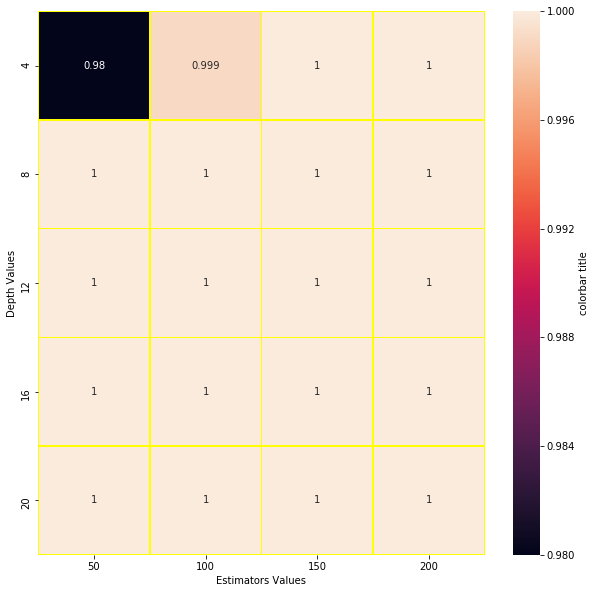

The Heatmap for Cross-Validation AUC scores is plotted below: 


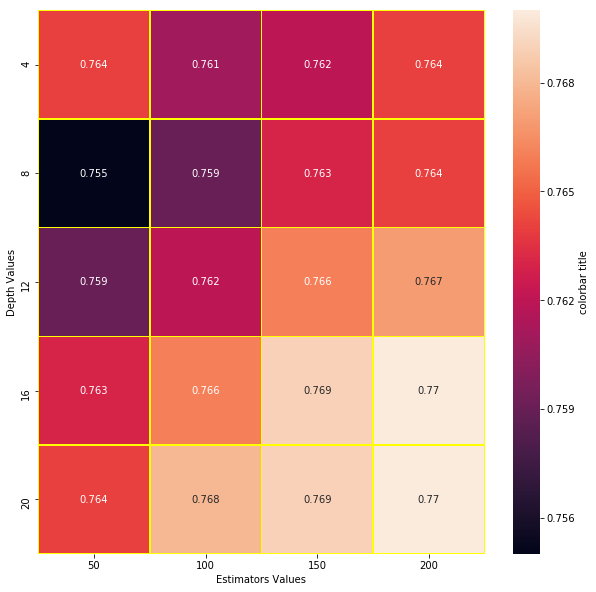

The best model obtained from our Gridsearch is:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.300000012, max_delta_step=0, max_depth=16,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=200, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=0.189, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None)
The best parameters obtained by our model is:  {'max_depth': 16, 'n_estimators': 200}
The AUC score for our model is is:  0.77


In [138]:
# find the optimal plane using grid search 

encoder = preprocessing.LabelEncoder()
enc = encoder.fit(y_train)
y_en_train= enc.transform(y_train)
y_en_test = enc.transform(y_test)

weight = sum(final_tf_w2v['Score']==0)/sum(final_tf_w2v['Score']==1)
weight = round(weight,3)

# print(X_train)
opt_gbdt = find_optimal_gbdt(X_trainf,y_en_train,3,weight)

In [141]:
opt_gbdt_best = opt_gbdt.best_estimator_
y_pred = pred_test_data(X_trainf,y_en_train,X_testf,y_en_test,opt_gbdt_best) 


The ROC_AUC score of the Decision Tree classifier is:  79.79064927520172


Confusion matrix is :  [[ 156  315]
 [ 157 2372]]
The True Positive value is:   2372
The True Negative value is:   156
The False Positive value is:   157
The False Negative value is:   315


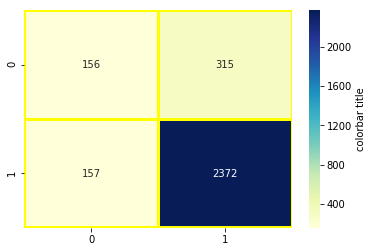

In [142]:
confusion_heatmap(y_en_test,y_pred)

In [143]:
#determining metrics precision,recall,f-1 scores for our model
metric_score(y_en_test,y_pred)

The precision score for our model is:  0.8827688872348344
The f1 score for our model is:  0.9095092024539877
The recall score for our model is:  0.9379201265322262
The accuracy of our model is:  0.8426666666666667


ytrain_prob = opt_gbdt_best.predict_proba(X_trainf)
ytrain_prob = ytrain_prob[:, 1]

ytest_prob = opt_gbdt_best.predict_proba(X_testf)
ytest_prob = ytest_prob[:,1]
#get the class probabilities for train and test to plot the roc curve 
plot_roc_curve(y_en_train,ytrain_prob,y_en_test,ytest_prob,'-',':',"train_roc_auc","test_roc_auc")

Conclusion:
1. GBDT with 3-fold validation was performed on a sample dataset of AFF for TF-IDF Word2vec vectors.
2. We chose the standard 70-30 split i.e. 70% as train data and 30% as test data.
4. Confusion matrix was plotted for the same. We got True Negative value of 156 and True Positive value of 2372.
5. The accuracy,precision, recall and f1 scores are 84.27 % , 88.27 %, 93.79 % and 90.95 % respectively. 


# [6] Conclusions

In [145]:
# Please compare all your models using Prettytable library

from prettytable import PrettyTable
    
x = PrettyTable(["METRIC", "B.O.W", "TF-IDF", "Avg w2v", "TF-IDF w2v", "Model" ])

x.add_row(["n_estimators",250, 250,200,250,"Random Forest" ])
x.add_row(["max_depth",20,24,24,24,"Random Forest" ])
x.add_row(["True Positive",23478,23903,24730,2505,"Random Forest" ])
x.add_row(["True Negative",3807,3728,2075,35,"Random Forest" ])
x.add_row(["Accuracy",90.95,92.10,89.35,84.67,"Random Forest" ])
x.add_row(["Precision",96.27, 96.02,90.35,85.17,"Random Forest" ])
x.add_row(["Recall",92.86,94.54,97.81,99.05,"Random Forest" ])
x.add_row(["F1 Scores",94.53,95.28,93.93,91.59,"Random Forest" ])
x.add_row(["AUC Scores",94.88, 95.66,92.74,77.73,"Random Forest" ])
x.add_row(["n_estimators",200,200,200,200,"GBDT" ])
x.add_row(["max_depth",20,12,12,16,"GBDT" ])
x.add_row(["True Positive",24089,23937,24107,2372,"GBDT" ])
x.add_row(["True Negative",3783,3996,3219,156,"GBDT" ])
x.add_row(["Accuracy",92.91,93.11,91.09,84.27,"GBDT" ])
x.add_row(["Precision",96.27, 97.08,94.15,88.28,"GBDT" ])
x.add_row(["Recall",95.28, 94.68,95.35,93.79,"GBDT" ])
x.add_row(["F1 Scores",95.77,95.86,94.74,90.95,"GBDT" ])
x.add_row(["AUC Scores",96.35, 96.83,93.97,79.79,"GBDT" ])

print(x)

+---------------+-------+--------+---------+------------+---------------+
|     METRIC    | B.O.W | TF-IDF | Avg w2v | TF-IDF w2v |     Model     |
+---------------+-------+--------+---------+------------+---------------+
|  n_estimators |  250  |  250   |   200   |    250     | Random Forest |
|   max_depth   |   20  |   24   |    24   |     24     | Random Forest |
| True Positive | 23478 | 23903  |  24730  |    2505    | Random Forest |
| True Negative |  3807 |  3728  |   2075  |     35     | Random Forest |
|    Accuracy   | 90.95 |  92.1  |  89.35  |   84.67    | Random Forest |
|   Precision   | 96.27 | 96.02  |  90.35  |   85.17    | Random Forest |
|     Recall    | 92.86 | 94.54  |  97.81  |   99.05    | Random Forest |
|   F1 Scores   | 94.53 | 95.28  |  93.93  |   91.59    | Random Forest |
|   AUC Scores  | 94.88 | 95.66  |  92.74  |   77.73    | Random Forest |
|  n_estimators |  200  |  200   |   200   |    200     |      GBDT     |
|   max_depth   |   20  |   12   |    